In [1]:
import requests
from io import StringIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf

Let's make some synthetic data. We will create:

- 3 years of data
- with 4 seasonal cycles per year
- we add a trend of +10 over the full period
- and we add some noise

(array([18262., 18383., 18506., 18628., 18748., 18871., 18993., 19113.,
        19236., 19358.]),
 [Text(18262.0, 0, '2020-01'),
  Text(18383.0, 0, '2020-05'),
  Text(18506.0, 0, '2020-09'),
  Text(18628.0, 0, '2021-01'),
  Text(18748.0, 0, '2021-05'),
  Text(18871.0, 0, '2021-09'),
  Text(18993.0, 0, '2022-01'),
  Text(19113.0, 0, '2022-05'),
  Text(19236.0, 0, '2022-09'),
  Text(19358.0, 0, '2023-01')])

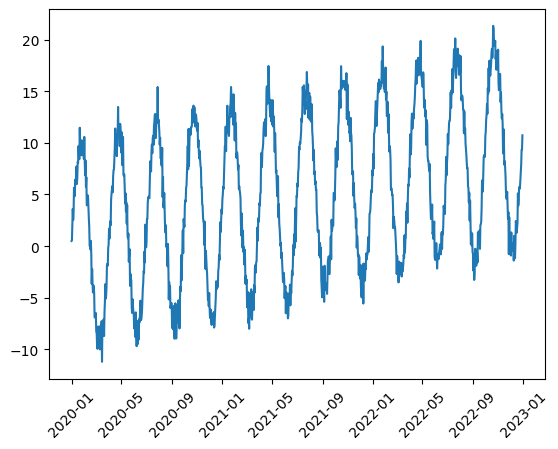

In [2]:
# Generate a date range
years = 3
dates = pd.date_range(start="2020-01-01", periods=365 * years, freq="D")

# Generate synthetic data with seasonality
cycles = 4
np.random.seed(42)
trend = np.linspace(0, 10, len(dates))  # Linear trend
seasonality = 10 * np.sin(
    np.linspace(0, cycles * years * 2 * np.pi, len(dates))
)  # Yearly seasonality
noise = np.random.normal(0, 1, len(dates))  # Random noise
synthetic_data = trend + seasonality + noise

# Create a DataFrame
df = pd.DataFrame({"Date": dates, "Value": synthetic_data})
plt.plot(df["Date"], df["Value"])
plt.xticks(rotation=45)

Autocorrelation, often visualized through Time Series Autocorrelation Plots (tsaplots), is a statistical measure used to determine the degree of similarity between a time series and a lagged version of itself over successive time intervals. It's essentially measuring how well the current values of the series are related to its past values. This relationship is quantified as a correlation coefficient, ranging from -1 to 1, where:

- 1 indicates a perfect positive correlation: as the time series increases (or decreases), the lagged series also increases (or decreases).
- -1 indicates a perfect negative correlation: as the time series increases, the lagged series decreases, and vice versa.
- 0 indicates no correlation: the time series and its lagged version do not show any linear relationship.

Motivation to Use Autocorrelation

1. Identifying Seasonality: One of the primary uses of autocorrelation plots is to identify seasonal patterns within time series data. If a time series is influenced by seasonality, the autocorrelation plot will exhibit regular, significant peaks at lags corresponding to the season's length. For example, a yearly seasonal pattern would show peaks at multiples of the seasonal period (e.g., every 12 months for monthly data).

2. Model Selection: Autocorrelation plots are invaluable in the model selection process for time series analysis. They help determine the appropriate type of models to fit the data, such as ARIMA (AutoRegressive Integrated Moving Average), by identifying the order of autoregressive (AR) or moving average (MA) components needed to capture the time series dynamics.

3. Data Preprocessing: By understanding the autocorrelation structure of a dataset, analysts can make informed decisions about data preprocessing steps, such as differencing or transformation, to make the series stationary—a common requirement for many time series modeling techniques.

4. Detecting Anomalies: Autocorrelation plots can also help in detecting anomalies or unusual patterns in the time series data that might not be apparent from simply looking at the time series plot. Significant deviations from the expected autocorrelation pattern can indicate outliers, structural breaks, or changes in the underlying process generating the series.

Text(0.5, 0.98, 'Autocorrelation Plot')

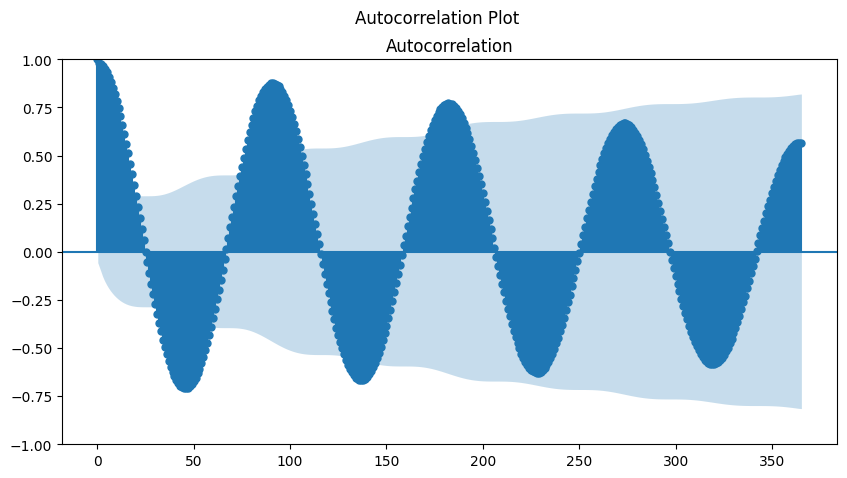

In [3]:
acf_plot = tsaplots.plot_acf(df["Value"], lags=365)

# Adjust the plot size
acf_plot.set_figheight(5)
acf_plot.set_figwidth(10)

# Show the plot
acf_plot.suptitle("Autocorrelation Plot")

In this plot, we can find the seasonality that we have added to the data!
As you can see, we have a maximum after about 90 days, which is exactly what we would expect from 4 seasonal cycles per year. 

We can extract the exact value of the lag with the highest autocorrelation using the `acf` function from the `statsmodels` library.

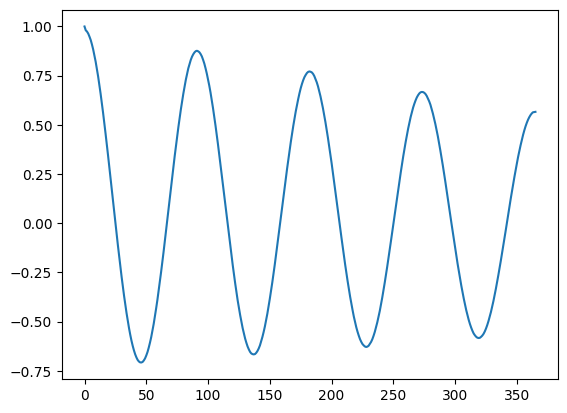

In [4]:
acf_values = acf(df["Value"], nlags=365)
plt.plot(acf_values)

Because the highest correlation is at lag 1, we skip the first part because we are interested in the second highest correlation.

In [5]:
skip = 50
lag = np.argmax(acf_values[skip:]) + skip
lag

np.int64(91)

Text(0.5, 0.98, 'Time Series Decomposition')

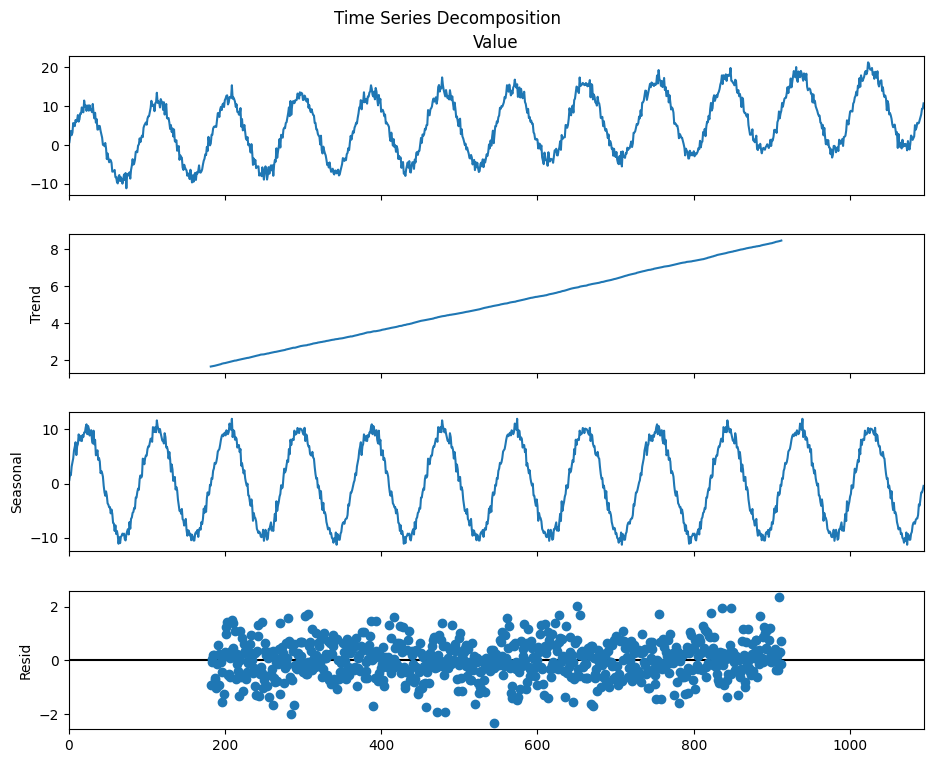

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
result = seasonal_decompose(df["Value"], model="additive", period=365)

# Plot the decomposed components
decomposed = result.plot()

decomposed.set_figheight(8)
decomposed.set_figwidth(10)
decomposed.suptitle("Time Series Decomposition")

This is essentially a deconstruction of how we created the data!

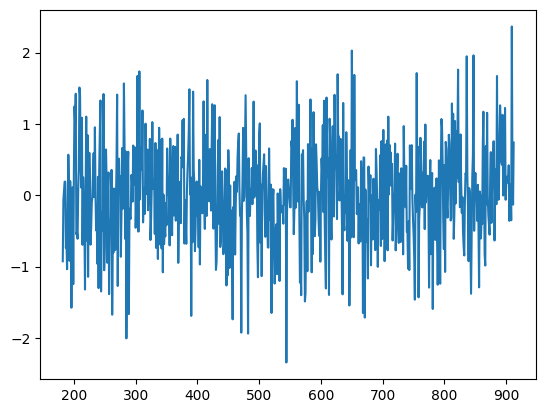

In [7]:
deseasonalised = df["Value"] - result.seasonal - result.trend
plt.plot(deseasonalised)

# Sunspots
Let's try this with data about sunspots. This dataset contains the number of sunspots observed each year from 1700 to 2008. This dataset is often used to demonstrate time series analysis techniques.

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/var/folders/hv/m4f2vdm11q911kmp31zcg4t40000gn/T/ipykernel_14922/324654705.py:6: SyntaxWarning: invalid escape sequence '\s'
  sep="\s+",


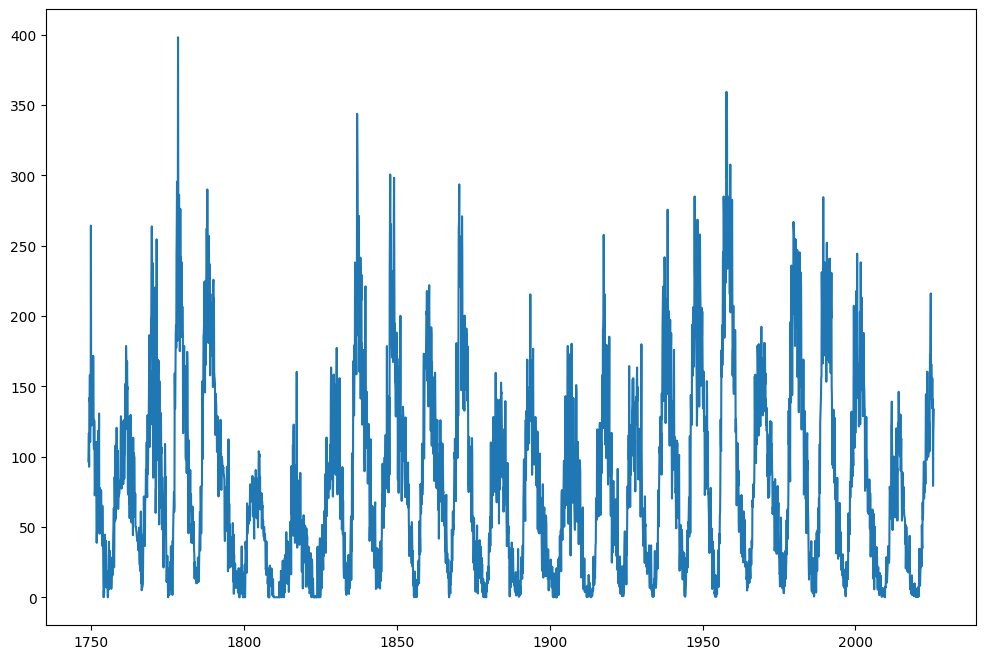

In [8]:
url = "https://www.sidc.be/SILSO/DATA/SN_m_tot_V2.0.txt"
response = requests.get(url, timeout=10)
data = StringIO(response.text)
df = pd.read_csv(
    data,
    sep="\s+",
    header=None,
    names=[
        "year",
        "month",
        "decimal_date",
        "sunspots",
        "std_dev",
        "observations",
        "definitive",
    ],
)
plt.figure(figsize=(12, 8))
plt.plot(df["decimal_date"], df["sunspots"])

Text(0.5, 0.98, 'Autocorrelation Plot')

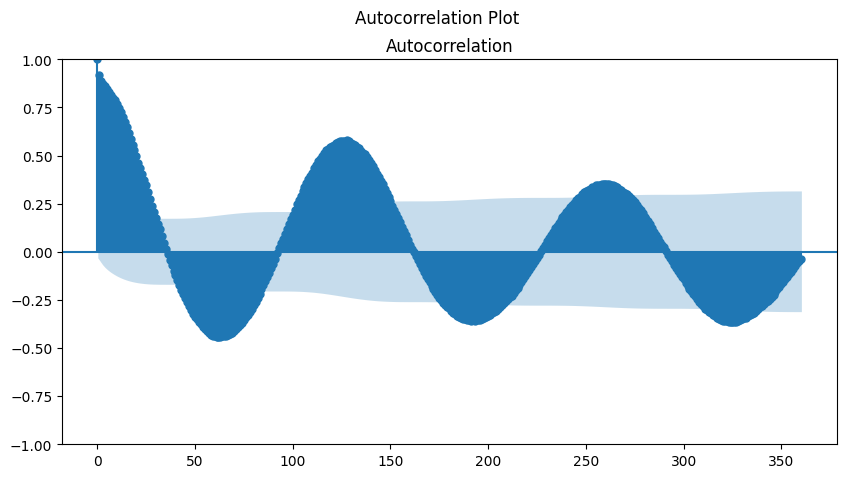

In [9]:
acf_plot = tsaplots.plot_acf(
    df["sunspots"], lags=30 * 12
)  # lets check for 30 years, 12 months each

# Adjust the plot size
acf_plot.set_figheight(5)
acf_plot.set_figwidth(10)

# Show the plot
acf_plot.suptitle("Autocorrelation Plot")

the 2nd highest correlated lag is 128 months


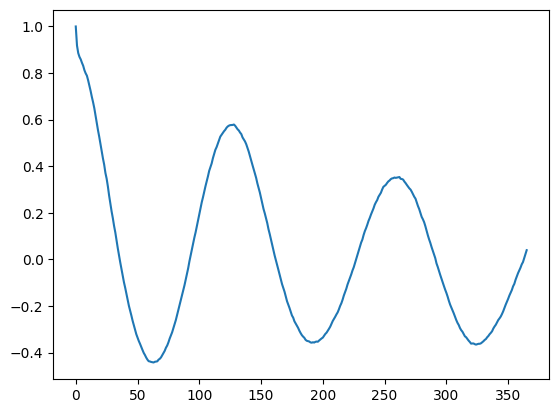

In [10]:
acf_values = acf(df["sunspots"], nlags=365)
skip = 50
lag = np.argmax(acf_values[skip:]) + skip
print(f"the 2nd highest correlated lag is {lag} months")
plt.plot(acf_values)

Text(0.5, 0.98, 'Time Series Decomposition')

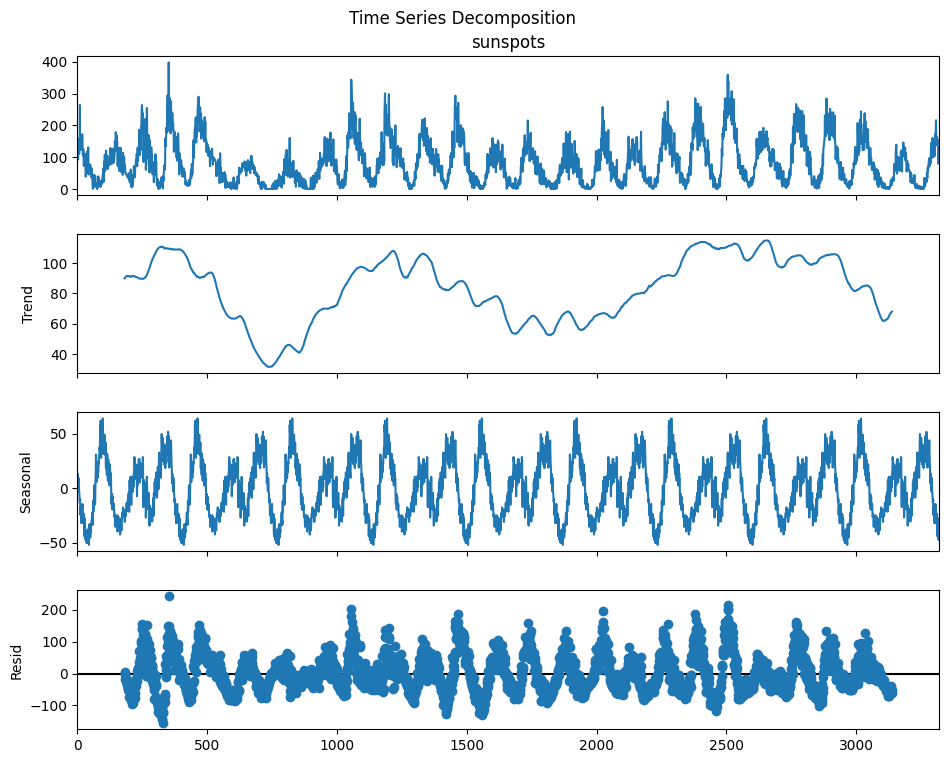

In [11]:
result = seasonal_decompose(df["sunspots"], model="additive", period=365)

decomposed = result.plot()
decomposed.set_figheight(8)
decomposed.set_figwidth(10)
decomposed.suptitle("Time Series Decomposition")

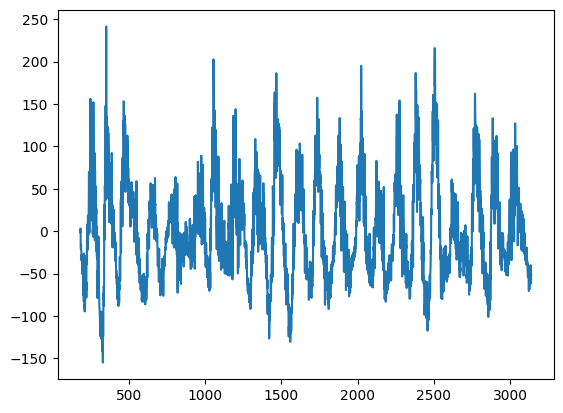

In [12]:
deseasonalised = df["sunspots"] - result.seasonal - result.trend
plt.plot(deseasonalised)

As you can see, the decomposition does not work as expected. The trend is a very long cycle, of more than 100 years. In addition to that, the seasonality does pick up some faster cycles, but the residual still has a lot of very distinct sine-wave patterns. This shows you that the underlying pattern is probably too complex to decompose for the algorithm the plot is using.

However, it is still very usefull because we do find some of the hidden patterns in the data.

# Fourier Transforms

In [13]:
import numpy as np
import pandas as pd
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt

Because the patterns are more complex in this timeseries, we will take another approach, using Fourier Transforms. The main idea behind the fourier transform is this: any complex pattern can be broken down into a series of sine waves, and the Fourier transform is a way to do this.

The fourier transform takes a complex pattern and breaks it down into a series of sine waves of different frequencies and amplitudes.

We will first illustrate this with our synthetic data

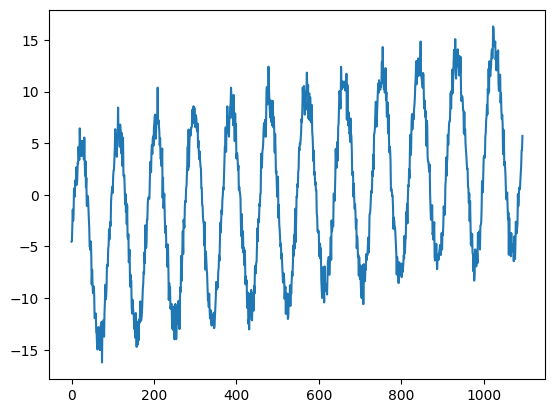

In [14]:
y = synthetic_data.copy()
y -= y.mean()
plt.plot(y)

In [15]:
def fourier_model(timeseries, k):
    # Calculate the number of data points in the timeseries
    t = 1.0
    n = len(timeseries)
    # Generate a time vector 'x' from 0 to n*t (excluding the endpoint) evenly spaced
    x = np.linspace(0.0, n * t, n, endpoint=False)
    # Perform the Fourier Transform of the timeseries
    yf = fft(timeseries)
    # Generate the frequency bins for the first half of the Fourier Transform result
    # This represents the positive frequencies up to the Nyquist frequency
    # the nyquist frequency is the highest frequency that can be represented in the fourier transform
    # it is half of the sampling frequency
    xf = fftfreq(n, t)[: n // 2]
    # Identify indices of the 'k' largest frequencies by their magnitude in the first half of the Fourier spectrum
    # the largest frequencies are the most important components of the signal
    indices = np.argsort(np.abs(yf[0 : n // 2]))[-k:]
    # Extract the frequencies corresponding to the 'k' largest magnitudes
    frequencies = xf[indices]
    # Calculate the amplitudes of these frequencies as twice the magnitude divided by n
    # This accounts for the symmetry of the Fourier Transform for real signals
    amplitudes = 2.0 / n * np.abs(yf[indices])
    # Extract the phases of these frequencies and adjust by adding pi/2 to align phases
    phases = np.angle(yf[indices]) + 1 / 2 * np.pi
    # Return a dictionary of the model parameters: 'x', 'frequencies', 'amplitudes', 'phases'
    return {
        "x": x,
        "frequencies": frequencies,
        "amplitudes": amplitudes,
        "phases": phases,
    }

This deconstruction gives us the top k with the highest amplitudes (and thus most important) sine waves, with which we can reconstruct (model) the original data. lets visualize our model

In [16]:
def model(parameters):
    # Extract the time vector 'x' from the parameters
    x = parameters["x"]
    # Extract the frequencies, amplitudes, and phases from the parameters
    frequencies = parameters["frequencies"]
    amplitudes = parameters["amplitudes"]
    phases = parameters["phases"]

    # Initialize a zero array 'y' of the same shape as 'x' to store the model output
    y = np.zeros_like(x)

    # Add each sine wave component to 'y' based on the extracted frequencies, amplitudes, and phases
    for freq, amp, phase in zip(frequencies, amplitudes, phases):
        y += amp * np.sin(2.0 * np.pi * freq * x + phase)

    # Return the composite signal 'y' as the sum of the sine wave components
    return y

And compare it with the orginal data

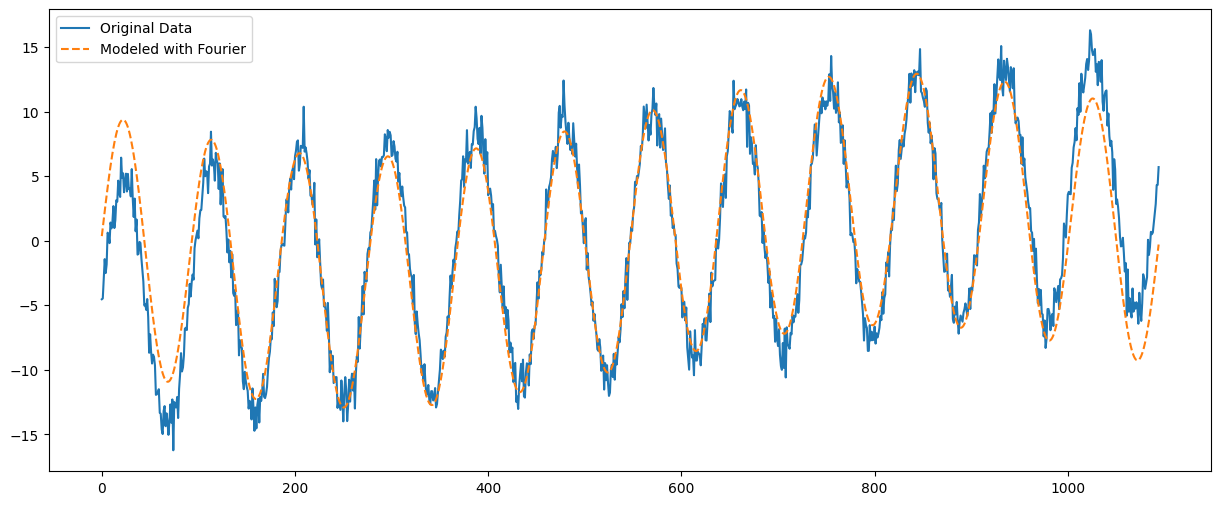

In [17]:
k = 2  # Number of Fourier components

parameters = fourier_model(y, k)
x = parameters["x"]
y_model = model(parameters)


def plot_model(x, y, y_model):
    plt.figure(figsize=(15, 6))
    plt.plot(x, y, label="Original Data")
    plt.plot(x, y_model, label="Modeled with Fourier", linestyle="--")
    plt.legend()
    plt.show()


plot_model(x, y, y_model)


Its not perfect, but pretty good! A nice extra is that we loose most of the noise.
Now, let us try the same with a subset of the sunspots data

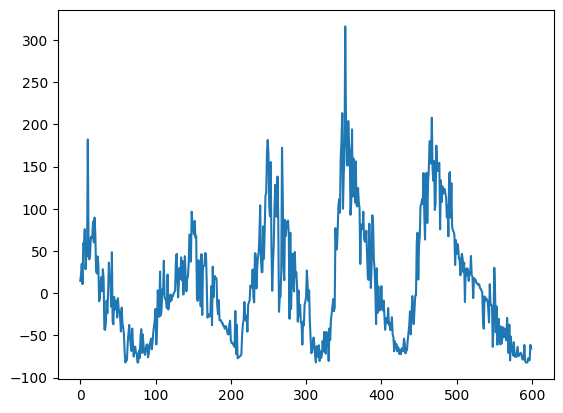

In [18]:
y = df["sunspots"].values.copy()
y -= y.mean()
y = y[: 12 * 50]  # first 50 years
plt.plot(y)  # first 50 years

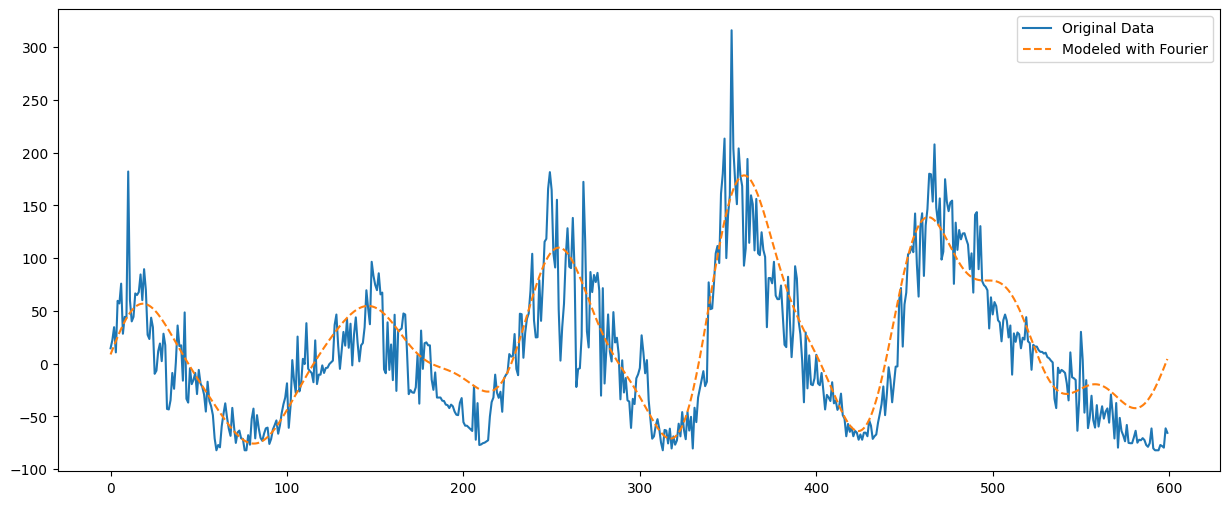

In [19]:
k = 9  # Number of Fourier components

parameters = fourier_model(y, k)
y_model = model(parameters)
x = parameters["x"]
plot_model(x, y, y_model)

While this seems like a nice result, we are probably overfitting the timeseries; it is very unlikely that this model gives us a solid prediction, because as you can see the model overfits on the noise of the data. However, it is a nice illustration of how this can work.

You could improve this model by doing things like:
- reduce the number of sine waves! This will make the model simpler, preventing overfitting
- fitting the model on a trainset (eg 50 years) and testing results on a testset (eg next 50 years)
- removing noise from the data with smoothing techniques
- talking to a domain expert by incorporating domain knowledge
- finding a way to model the very long (+100 year) cycle we found with statsmodels decomposition
- finding better ways to account for the non-symmetric shape of the data than simply subtracting the mean

Below you will find a short crash course into smoothing; however, this is a course on visualisation so we will only scratch the surface of this topic.
In the course on Machine Learning we will go much deeper into this topic, but we will also let the neural networks figure out what the best filters are. 
Regardless, it can be usefull to do some feature engineering, especially on timeseries.

# Smoothing with Scipy filters

1. Savitzky-Golay Filter: This filter essentially fits successive sub-sets of adjacent data points with a low-degree polynomial by the method of linear least squares. It's good for preserving the original shape and features of the signal while smoothing.

2. Low-pass Butterworth Filter: This is a type of signal processing filter designed to have a frequency response as flat as possible in the passband. It's effective in reducing the noise while keeping the sharpness of the signal transitions.

The parameters for filtering techniques like the Savitzky-Golay filter and the Low-pass Butterworth filter are crucial for achieving the desired smoothing effect without significantly distorting the signal. These parameters must be chosen carefully, often based on both the characteristics of the signal (e.g., frequency content, noise characteristics) and empirical testing.

## Types of Filters
### Savitzky-Golay Filter

- Window Size: This is the number of data points used to fit the polynomial. A larger window will result in smoother signals but can also smear out rapid changes. The window size must be odd and large enough to encompass enough points to perform a meaningful fit. Typically, you'd start with a window size that captures the duration of the features of interest in your signal and adjust based on empirical results.

- Polynomial Order: This is the degree of the polynomial used to fit the slices of your data. A higher order can fit the data more closely, but if it's too high, it can lead to overfitting, where the filter starts to follow the noise rather than the underlying signal trend. A good starting point is a low order (e.g., 2 or 3) and increasing it only if the smoothing is not sufficient and the signal's features allow for a more complex fit.
### Low-pass Butterworth Filter

- Cutoff Frequency: This defines the frequency at which the filter starts to attenuate the signal. Frequencies lower than the cutoff pass through largely unchanged, while frequencies higher are reduced. The cutoff frequency should be chosen based on the frequency content of your signal and the noise. For instance, if your signal has important features at low frequencies and noise at high frequencies, you'd set the cutoff just above the highest frequency of interest. It's often expressed as a fraction of the Nyquist frequency (half the sampling rate).

- Filter Order (the parameter 3 in the butter function): This determines the steepness of the filter's transition from passband to stopband. A higher order means a steeper transition but can also lead to more ringing artifacts (Gibbs phenomenon) and phase distortion. A lower order results in a gentler slope. The choice of order is a balance between adequately attenuating noise while minimizing signal distortion. Starting with a low order (e.g., 3 or 4) is common, and then it can be adjusted based on the performance.
## General Guidelines

- Empirical Testing: The best parameters often come from empirical testing and understanding the nature of your signal. Visualization tools (like plotting the filtered signal) are invaluable for assessing the effectiveness of your chosen parameters.
- Signal Characteristics: Consider the characteristics of your signal (e.g., the frequency of interest, the expected shape of the signal, the nature of the noise) when choosing parameters.
- Iterative Approach: Start with general rules of thumb and then iteratively adjust based on the results. Filtering is often more of an art than a science, requiring some experimentation.

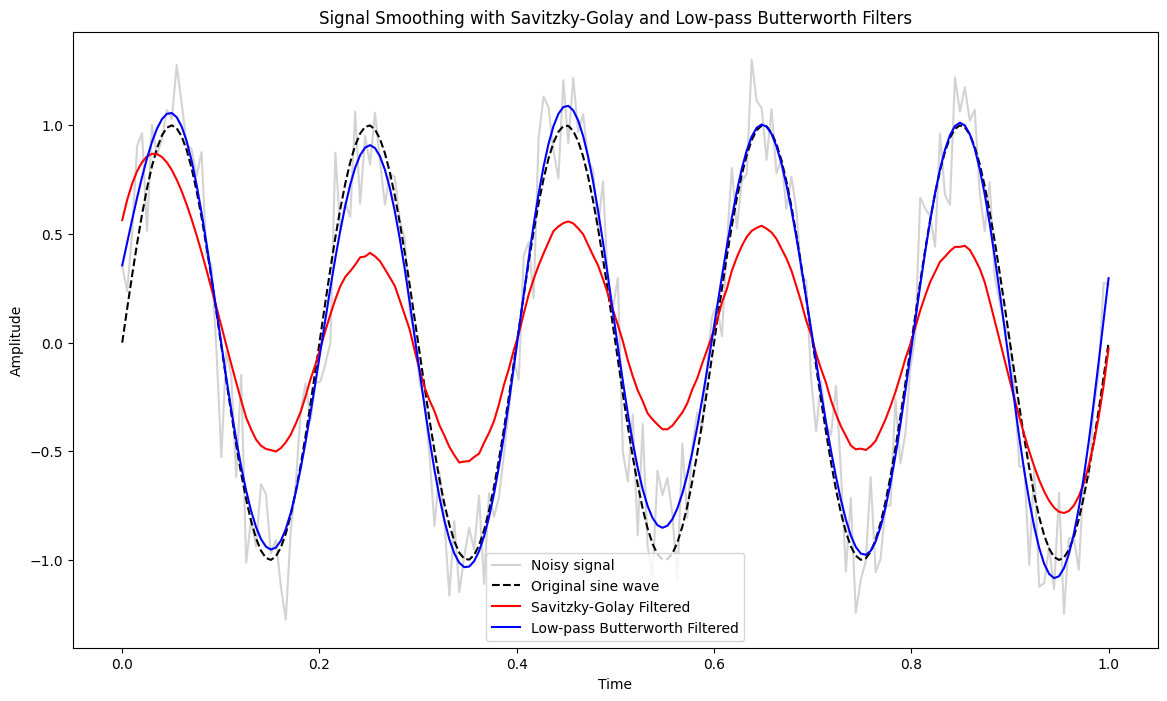

In [20]:
from scipy.signal import savgol_filter, butter, filtfilt

# Generate a noisy sine wave for demonstration
np.random.seed(0)  # For reproducibility
time = np.linspace(0, 1, 200)  # 1 second, 200 samples
frequency = 5  # Frequency of the sine wave
amplitude = 1  # Amplitude of the sine wave
noise = np.random.normal(0, 0.2, time.shape)  # Gaussian noise
sine_wave = amplitude * np.sin(2 * np.pi * frequency * time)
noisy_signal = sine_wave + noise

# Apply Savitzky-Golay filter
window_size = 51  # Window size should be odd
poly_order = 3  # Polynomial order
savitzky_golay_filtered = savgol_filter(noisy_signal, window_size, poly_order)

# Apply Low-pass Butterworth filter
cutoff_frequency = 0.1  # Cutoff frequency as a fraction of the sampling rate
filter_order = 3  # Filter order
b, a = butter(filter_order, cutoff_frequency, btype="low", analog=False)
butterworth_filtered = filtfilt(b, a, noisy_signal)

# Plot the original and filtered signals
plt.figure(figsize=(14, 8))
plt.plot(time, noisy_signal, label="Noisy signal", color="lightgray")
plt.plot(time, sine_wave, label="Original sine wave", linestyle="--", color="black")
plt.plot(time, savitzky_golay_filtered, label="Savitzky-Golay Filtered", color="red")
plt.plot(
    time, butterworth_filtered, label="Low-pass Butterworth Filtered", color="blue"
)
plt.legend()
plt.title("Signal Smoothing with Savitzky-Golay and Low-pass Butterworth Filters")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()